<img src="tic3151.png" style="height: 70px; width: 200px" align=left> 
<img src="logo-MMU.png" style="height: 70px; width: 200px" align=right> 

### Team members

Ahmad Ayaan - 1191302794 

Salah Fayeq y. AlHaismawi - 1201303035

Aisha Sakinah Binti Saadon - 1191101867

Aryssa Amanda Binti Azhar - 1191100575


### The assignment contains following questions


# Installing Libraries

##### Note: Uncomment the code the code to install the relevant libraries

In [1]:
# pip install ortools
# pip install pulp

# Importing Libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from ortools.sat.python import cp_model
from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# Question 1

Year-end school holiday is coming soon. A kindergarten teacher would like to give each
of the student in her class, an amazing holiday set by November 2023. There are 25
students in her class consisting of 15 girls and 10 boys. She has approached you for
help and provided the following details to you:

• Budget for 25 holiday sets = RM 200.00

• Each holiday set must be wrapped using a sheet of paper i.e. blue wrapper for
boy’s holiday set and pink wrapper for girl’s holiday set. Each wrapper cost
RM1.00

• Each holiday set should have at least 2 items being stationery



## Variables Declaration

In [3]:
# Constant variables
budget = 200.00
minimum_stationary_item = 2
wrapper_cost = 1.00

# List of items and their prices
items = [
    ("Chipsmore Biscuit", 2.00),
    ("2B pencil", 1.00),
    ("Color pencil", 3.00),
    ("Magic pen", 3.00),
    ("Potato chip", 2.00),
    ("Milo packet", 1.00),
    ("Mini sketch book", 2.00),
    ("Milk biscuit", 3.00)
]

mutation_rate = 0.1
wrapper_cost = 1 * 25  # Wrapper cost for 25 sets

## Population and Individuals



In [4]:
def individuals():
    return [random.randint(0, 1) for items in range(len(items))]

def generate_population(population_size):
    return [individuals() for x in range(population_size)]

## Fitness Function

The fitness function calculates the total cost of items in a chromosome, after deducting the cost of wrappers and ensuring that atleast 2 of the items are stationery.

In [5]:
def fitness_function(chromosome):
    total = 0
    num_stationery_items = 0
    num_items = 0
    for i, j in enumerate(chromosome):
        if j == 1:
            # to calculate the total cost of the items present in the set
            total += items[i][1]
            num_items += 1
            # to check if the current sets have stationery
            if items[i][0] in ["2B pencil", "Color pencil", "Magic pen", "Mini sketch book"]:
                num_stationery_items += 1

    if num_stationery_items >= 2 and (total*25) + wrapper_cost <=budget:
         # Calculate the fitness score based on the weighted sum of total cost and number of items
        total_score = total * num_items
        items_score = num_items * 10
        score = total_score + items_score
        #print(score)
        return score
    else:
        return 0 if total <= 200 else -1

## Selection Function

In [6]:
"""Perform selection using roulette wheel selection."""
def selection_roulette_wheel(population, fitness_values):
    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        probabilities = [fitness / total_fitness for fitness in fitness_values]
    selected = random.choices(population, weights=probabilities, k=2)
    return selected[0], selected[1]


"""Perform selection using rank selection."""
def selection_rank(population, fitness_values):
    ranked_population = sorted(zip(population, fitness_values), key=lambda x: x[1], reverse=True)
    selected = []
    while len(selected) < 2:
        for chromosome, fitness in ranked_population:
            if fitness > 0:  # Select only individuals with positive fitness
                selected.append(chromosome.copy())
                if len(selected) == 2:
                    break
    return selected[0], selected[1]


## Crossover Function

In [7]:
"""Perform crossover using single point crossover."""
def crossover_single_point(parent1, parent2):
    single_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:single_point] + parent2[single_point:]
    child2 = parent2[:single_point] + parent1[single_point:]
    return child1, child2

"""Perform crossover using two point crossover."""
def crossover_two_point(parent1, parent2):
    two_point = sorted(random.sample(range(len(parent1)), 2))
    child1 = parent1[:two_point[0]] + parent2[two_point[0]:two_point[1]] + parent1[two_point[1]:]
    child2 = parent2[:two_point[0]] + parent1[two_point[0]:two_point[1]] + parent2[two_point[1]:]
    return child1, child2

## Mutation Function

In [8]:
"""Perform inversion mutation."""
def mutation_inversion(chromosome):
    start = random.randint(0, len(chromosome) - 1)
    end = random.randint(start + 1, len(chromosome))
    mutated_chromosome = chromosome[:start] + chromosome[start:end][::-1] + chromosome[end:]
    return mutated_chromosome

"""Perform bit flipping mutation."""
def mutation_bit_flip(chromosome):
    mutated_chromosome = chromosome[:]
    for i in range(len(mutated_chromosome)):
        if random.random() < 0.1:  # 10% chance for bit flipping
            mutated_chromosome[i] = 1 - mutated_chromosome[i]
    return mutated_chromosome

## Main Function

In [9]:
def evolve(population, fitness_values, selection_method, crossover_method, mutation_method):
    next_generation = []
    while len(next_generation) < 25:
        parent1, parent2 = selection_method(population, fitness_values)
        offspring1, offspring2 = crossover_method(parent1, parent2)
        next_generation.extend([offspring1, offspring2])
        #print(next_generation)
    num_mutations = int(0.05 * len(next_generation))  # 5% of the population
    mutated_population = random.sample(next_generation, num_mutations)
    for i in range(num_mutations):
        mutated_chromosome = mutation_method(mutated_population[i])
        next_generation[i] = mutated_chromosome
    return next_generation[:25]

In [10]:
def main(population, selection_method, crossover_method, mutation_method):
    # Calculate fitness values for each chromosome
    avg_fitness_history = []
    fitness_values = [fitness_function(chromosome) for chromosome in population]

    best_fitness = float('inf')
    best_combination = []

    for generation in range(150):
        # Select parents and perform crossover and mutation
        population = evolve(population, fitness_values, selection_method, crossover_method, mutation_method)

        # Calculate fitness values for each chromosome
        fitness_values = [fitness_function(chromosome) for chromosome in population]
        avg_fitness_history.append(sum(fitness_values) / len(fitness_values))

       # Find the best fitness value and corresponding combination
        best_fitness = max(fitness_values)
    best_combination = population[fitness_values.index(best_fitness)].copy()

    # Display the total combination and the content of the combination
    print("Total Combination of Items: ")
    total_combination = sum(best_combination)
    print(total_combination)

    print("Content of the Combination of Items:")
    selected_items = []
    unit_price = 0
    for i, item in enumerate(best_combination):
        if item == 1:
            item_name = items[i][0]
            item_price = items[i][1]
            unit_price += item_price
            selected_items.append([item_name, item_price])
            
    selected_items.append(['Wrapper cost', '1'])
    unit_price +=1
    print(tabulate(selected_items, headers=["Item Name", "Price (RM)"], tablefmt="grid"))

    print("Unit Price: ")
    print(unit_price if best_fitness >= 0 else 0)
    
    print("Total Price: ")
    print(unit_price * 25 if best_fitness >= 0 else 0)
    
    return best_combination, avg_fitness_history

## Perfomance Assessment



In [116]:
# Generate an initial population
population = generate_population(25)

In [115]:
# Test 1
# Selection Method: Ranked
# Crossover Method: Single Point
# Mutation Method: Inversion

print("Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):")
print()
best_holiday_set_1, avg_fitness_history_1 = main(population, selection_rank, crossover_single_point, mutation_inversion)

Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):

Total Combination of Items: 
4
Content of the Combination of Items:
+-------------------+--------------+
| Item Name         |   Price (RM) |
+===================+==============+
| Chipsmore Biscuit |            2 |
+-------------------+--------------+
| 2B pencil         |            1 |
+-------------------+--------------+
| Potato chip       |            2 |
+-------------------+--------------+
| Mini sketch book  |            2 |
+-------------------+--------------+
| Wrapper cost      |            1 |
+-------------------+--------------+
Unit Price: 
8.0
Total Price: 
200.0


In [117]:
# Test 1
# Selection Method: Roulette wheel
# Crossover Method: Two Point
# Mutation Method: Bit Flip

print("Best holiday set (Selection Method: Roulette wheel, Crossover Method: Two Point, Mutation Method: Bit Flip):")
print()
best_holiday_set_2, avg_fitness_history_2 = main(population, selection_roulette_wheel, crossover_two_point, mutation_bit_flip)

Best holiday set (Selection Method: Rolette wheel, Crossover Method: Two Point, Mutation Method: Inversion):

Total Combination of Items: 
4
Content of the Combination of Items:
+-------------------+--------------+
| Item Name         |   Price (RM) |
+===================+==============+
| Chipsmore Biscuit |            2 |
+-------------------+--------------+
| 2B pencil         |            1 |
+-------------------+--------------+
| Potato chip       |            2 |
+-------------------+--------------+
| Mini sketch book  |            2 |
+-------------------+--------------+
| Wrapper cost      |            1 |
+-------------------+--------------+
Unit Price: 
8.0
Total Price: 
200.0


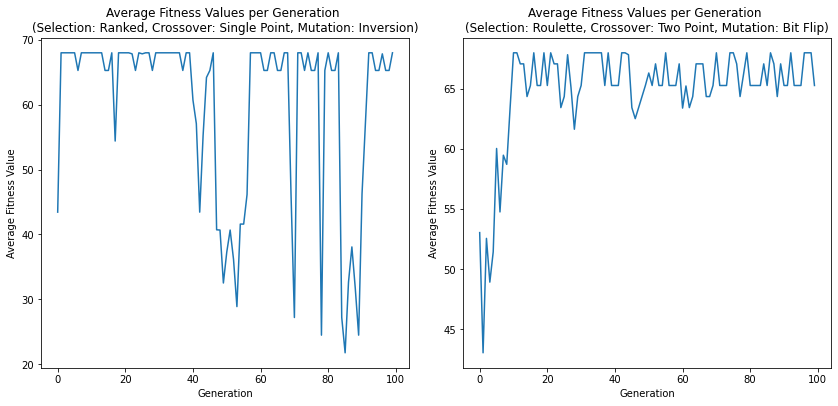

In [118]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Best holiday set (Selection Method: Ranked wheel, Crossover Method: Single Point, Mutation Method: Inversion)
x1 = range(len(avg_fitness_history_1))
y1 = avg_fitness_history_1

ax1.plot(x1, y1)
ax1.set_title("Average Fitness Values per Generation \n(Selection: Ranked, Crossover: Single Point, Mutation: Inversion)")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Average Fitness Value")

# Plot for Best holiday set (Selection Method: Roulette wheel, Crossover Method: Two Point, Mutation Method: Bit Flip)
x2 = range(len(avg_fitness_history_2))
y2 = avg_fitness_history_2

ax2.plot(x2, y2)
ax2.set_title("Average Fitness Values per Generation \n(Selection: Roulette, Crossover: Two Point, Mutation: Bit Flip)")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Average Fitness Value")

plt.tight_layout(pad=2.0)  # Add more padding between subplots

plt.show()


## Summary


# Question 2



The head of village ABC plans to hold a dodol feast for four consecutive days and have 
this feast recorded live in FB as part of promoting the village to outsiders. At the end of 
the dodol feast, the dodol will be shared with villagers and visitors to village ABC. The 
process of making the dodol, a sweet delicacy, is tedious and it requires a lot of strength 
to continuously stir the big pot of dodol to avoid it from being burnt. 

The villagers have been divided into seven teams to stir a pot of dodol on a rotation 
basis for the next four days. The pot of dodol will be stirred by one team at one time. 
Each team will stir the pot of dodol for four hours before another team takes over the 
task of stirring the pot of dodol. Ideally, no team will stir the pot of dodol for more than 
4 hours a day so that each team gets sufficient rest before their next turn to stir the pot 
of dodol. Each team will stir the pot of dodol for at least 8 hours during the entire dodol 
feast.

Formulate the problem as Constraint Satisfaction Problem

## Choice of Packages to use

Initially we were set to use python constraint package to solve this problem. However we have faced some problems while dealing with that package.
### Issues with constraint package
- The package has barely any documentation to refer to.
- The package is deprecated where the last version was released in 2018
- unpredictable behavior when dealing with the logic in constraints

## Variable declaration

In [ ]:
# Define the teams, days, and slots
slots = [1, 2, 3, 4, 5, 6]
teams = [1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4]
solution_limit = 100  # Number of solutions to print
teams_labels = ["Team 1", "Team 2", "Team 3", "Team 4", "Team 5", "Team 6", "Team 7"]

## Solve Dodol Function

In [ ]:
def solve_dodol_feast(minimum_slot):
     # Create the CP-SAT model
    model = cp_model.CpModel()

    # Create the decision variables
    variables = {}
    for day in days:
        for slot in slots:
            for team in teams:
                variables[(day, slot, team)] = model.NewBoolVar(f'time_{team}_{day}_{slot}')

    # Constraint 1: Each team must stir the pot for at least 3 times during the feast
    for team in teams:
        model.Add(sum(variables[(day, slot, team)] for day in days for slot in slots) >= minimum_slot)

    # Constraint 2: No team should stir the pot for more than 4 hours a day
    for day in days:
        for team in teams:
            model.Add(sum(variables[(day, slot, team)] for slot in slots) <= 1) #Sum of the slots each team is working daily should be less than or equal to 1

    # Constraint 3: No team should stir the pot consecutively
    for day in days:
        for slot in slots[1:]:
            for team in teams:
                model.Add(variables[(day, slot, team)] <= sum(variables[(day, slot - 1, t)] for t in teams if t != team)) #indexing over the values to make sure the sum of the previous slot is not equal to the current slot

    # Constraint 4: Only one team should stir the pot in each time slot
    for day in days:
        for slot in slots:
            model.Add(sum(variables[(day, slot, team)] for team in teams) == 1) #Sum of the teams working in each slot should be equal to 1

    # Create the objective variable
    objective_var = model.NewIntVar(0, len(days) * len(slots) * len(teams), 'objective') #Objective variable is the total number of team assignments

    # Constraint 5: Minimize the total number of team assignments
    model.Add(objective_var == sum(variables[(day, slot, team)] for day in days for slot in slots for team in teams)) #Sum of the team assignments should be equal to the objective variable

    # Set the objective function
    model.Minimize(objective_var) #Use the Minimize built-in function to minimize the objective variable to achieve the minimum number of team assignments

    # Create the solver
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    solutions_found = 0
    all_solutions = []

    while solutions_found < solution_limit: 
        status = solver.Solve(model)

        # Check if a solution is found
        if status != cp_model.OPTIMAL:
            print("No feasible solution found.")
            break

        # Extract the solution
        solution = {}
        for day in days:
            for slot in slots:
                for team in teams:
                    if solver.BooleanValue(variables[(day, slot, team)]):
                        solution[(day, slot)] = team

        all_solutions.append(solution)
        solutions_found += 1

        # Add a new constraint to prevent finding the same solution again
        model.Add(sum(variables[(day, slot, team)] for day in days for slot in slots for team in teams
                      if solution.get((day, slot)) == team) <= len(solution) - 1)

    return all_solutions

## Main Functions

In [15]:
# Solve the dodol feast problem and get all possible schedules
all_solutions_1 = solve_dodol_feast(2)

if all_solutions_1:
    solution_idx = 0  # Index of the solution to print (99 for the first solution)
    solution = all_solutions_1[solution_idx]
    print(f"Sample Schedule:")
    table = []
    for day in days:
        row = [f"Day {day}"]
        for slot in slots:
            team = solution.get((day, slot), "-")
            row.append(f"Team {team}")
        table.append(row)
    headers = [""] + [f"Time Slot {slot}" for slot in slots]
    print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))
    print()
else:
    print("No feasible solution found.")


Sample Schedule:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
|       | Time Slot 1   | Time Slot 2   | Time Slot 3   | Time Slot 4   | Time Slot 5   | Time Slot 6   |
+=======+===============+===============+===============+===============+===============+===============+
| Day 1 | Team 7        | Team 6        | Team 5        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 2 | Team 7        | Team 5        | Team 4        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 3 | Team 6        | Team 5        | Team 4        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 4 | Team 7        | Tea

In [16]:
# Solve the dodol feast problem and get all possible schedules
all_solutions_2 = solve_dodol_feast(3)

if all_solutions_2:
    solution_idx = 0  # Index of the solution to print (0 for the first solution)
    solution = all_solutions_2[solution_idx]
    print(f" Sample Schedule:")
    table = []
    for day in days:
        row = [f"Day {day}"]
        for slot in slots:
            team = solution.get((day, slot), "-")
            row.append(f"Team {team}")
        table.append(row)
    headers = [""] + [f"Time Slot {slot}" for slot in slots]
    print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))
    print()
else:
    print("No feasible solution found.")


## Visualise to show the constrast

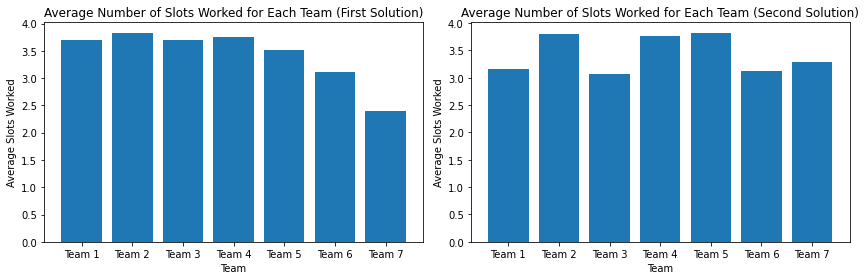

In [17]:
# Calculate the average number of slots worked for each team (First Solution)
team_slots_1 = {team: 0 for team in teams}
for solution in all_solutions_1:
    for team in teams:
        team_slots_1[team] += sum(1 for day in days for slot in slots if solution.get((day, slot)) == team)

average_slots_1 = {team: slots / len(all_solutions_1) for team, slots in team_slots_1.items()}

# Calculate the average number of slots worked for each team (Second Solution)
team_slots_2 = {team: 0 for team in teams}
for solution in all_solutions_2:
    for team in teams:
        team_slots_2[team] += sum(1 for day in days for slot in slots if solution.get((day, slot)) == team)

average_slots_2 = {team: slots / len(all_solutions_2) for team, slots in team_slots_2.items()}

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first solution
axes[0].bar(teams_labels, [average_slots_1[team] for team in teams])
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Average Slots Worked')
axes[0].set_title('Average Number of Slots Worked for Each Team (First Solution)')

# Plot the second solution
axes[1].bar(teams_labels, [average_slots_2[team] for team in teams])
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Average Slots Worked')
axes[1].set_title('Average Number of Slots Worked for Each Team (Second Solution)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Ranking Criteria: Inclusion

In a scheduling problem, one crucial criterion to measure the quality of a solution is inclusivity. A higher-quality solution is determined by ensuring that all teams participate equally, with minimal time differences.

## Conventional Method, with unoptimized paremeters
When initially approaching the problem, we followed the given instructions, which stated that each team should participate for a minimum of 8 hours throughout the entire feast. This approach, as shown in Figure 1, resulted in a semi-optimal solution where each team participated as equally as possible. However, we realized that the solution could be further optimized to better meet our criteria.

## Conventional Method, with optimized paremeters
By making a slight modification to the problem parameters, we were able to achieve improved results in terms of equal participation for each team. We raised the minimum working hours for the entire feast from 8 to 12. As depicted in Figure 2, we can observe that the disparity between the hours worked by each team is more evenly distributed.

### Justification for optimizing the parameters
The justification for optimizing the parameters lies in our understanding of the variables involved and calculating the most optimal minimum working hours for each team to promote better inclusion. A slot in our scheduling system represents a 4-hour time interval. Therefore, a day contains 6 slots, and the entire feast comprises 24 slots. If we divide these 24 slots equally among the 7 teams, we would get 24 / 7 = 3.428 slots per team. Since we are working with 4-hour slots, rounding this value to the nearest integer results in 3 slots. Consequently, allocating 3 slots (12 hours) to each team would achieve better inclusivity.

## Summary

The Dodle Feast problem is a scheduling constraint satisfaction problem, so in order to maximise performance and accuracy, it is necessary to assess the problem description and choose the ideal library. We carefully created constraints based on a thorough understanding of the variables involved to align our code with the issue. Through investigation, we discovered a chance for further optimisation: raising the minimum work hours from eight to twelve hours. By making this change, we hoped to improve inclusion within teams. We used charts to compare the initial and optimised solutions visually, demonstrating that the latter was superior in terms of inclusion. In conclusion, understanding variables, exact constraint formulation, analysis for optimisation, and visual appraisal of solutions were all necessary to solve the Dodle Feast problem, which finally led to a more comprehensive scheduling solution.

# Question 3


As an expert in data analytics, you are hired to analyse sports data. Given the NBA 
datasets, build TWO classification and ONE cluster analysis programs in Python.

You are allowed to add ONE additional and relevant data as supplementary data to assist 
you to do further analysis but the given datasets will serve as main dataset for analysis.

## Part 1: Data Cleaning

## Player List Dataset

### Import dataset

In [19]:
# Load data
playerlist = pd.read_csv("Question-3-Dataset/NBA-playerlist.csv")
playerlist 

,Unnamed: 0,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PERSON_ID,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,0,Alaa Abdelnaby,"Abdelnaby, Alaa",1990,Y,0,76001,HISTADD_alaa_abdelnaby,0,NaN,NaN,NaN,0,NaN,1994
1,1,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",1968,Y,0,76002,HISTADD_zaid_abdul-aziz,0,NaN,NaN,NaN,0,NaN,1977
2,2,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",1969,Y,0,76003,HISTADD_kareem_abdul-jabbar,0,NaN,NaN,NaN,0,NaN,1988
3,3,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",1990,Y,0,51,mahmoud_abdul-rauf,0,NaN,NaN,NaN,0,NaN,2000
4,4,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",1997,Y,0,1505,tariq_abdul-wahad,0,NaN,NaN,NaN,0,NaN,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,4388,Ante Zizic,"Zizic, Ante",2017,Y,1,1627790,ante_zizic,0,NaN,NaN,NaN,0,NaN,2018
4389,4389,Jim Zoet,"Zoet, Jim",1982,Y,0,78647,HISTADD_jim_zoet,0,NaN,NaN,NaN,0,NaN,1982
4390,4390,Bill Zopf,"Zopf, Bill",1970,Y,0,78648,HISTADD_zip_zopf,0,NaN,NaN,NaN,0,NaN,1970
4391,4391,Ivica Zubac,"Zubac, Ivica",2016,Y,1,1627826,ivica_zubac,0,NaN,NaN,NaN,0,NaN,2018


In [20]:
# Drop unnecessary columns
playerlist = playerlist.drop(['Unnamed: 0', 'DISPLAY_LAST_COMMA_FIRST'], axis=1)
playerlist = playerlist.rename(columns={'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})

# Rearrange the columns
person_id_col = playerlist.pop('PERSON_ID')  # Remove 'PERSON_ID' column from DataFrame
playerlist.insert(0, 'PERSON_ID', person_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
playerlist

,PERSON_ID,PLAYER_NAME,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,76001,Alaa Abdelnaby,1990,Y,0,HISTADD_alaa_abdelnaby,0,NaN,NaN,NaN,0,NaN,1994
1,76002,Zaid Abdul-Aziz,1968,Y,0,HISTADD_zaid_abdul-aziz,0,NaN,NaN,NaN,0,NaN,1977
2,76003,Kareem Abdul-Jabbar,1969,Y,0,HISTADD_kareem_abdul-jabbar,0,NaN,NaN,NaN,0,NaN,1988
3,51,Mahmoud Abdul-Rauf,1990,Y,0,mahmoud_abdul-rauf,0,NaN,NaN,NaN,0,NaN,2000
4,1505,Tariq Abdul-Wahad,1997,Y,0,tariq_abdul-wahad,0,NaN,NaN,NaN,0,NaN,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,1627790,Ante Zizic,2017,Y,1,ante_zizic,0,NaN,NaN,NaN,0,NaN,2018
4389,78647,Jim Zoet,1982,Y,0,HISTADD_jim_zoet,0,NaN,NaN,NaN,0,NaN,1982
4390,78648,Bill Zopf,1970,Y,0,HISTADD_zip_zopf,0,NaN,NaN,NaN,0,NaN,1970
4391,1627826,Ivica Zubac,2016,Y,1,ivica_zubac,0,NaN,NaN,NaN,0,NaN,2018


In [21]:
# Check data types
playerlist.dtypes

PERSON_ID                     int64
PLAYER_NAME                  object
FROM_YEAR                     int64
GAMES_PLAYED_FLAG            object
OTHERLEAGUE_EXPERIENCE_CH     int64
PLAYERCODE                   object
ROSTERSTATUS                  int64
TEAM_ABBREVIATION            object
TEAM_CITY                    object
TEAM_CODE                    object
TEAM_ID                       int64
TEAM_NAME                    object
TO_YEAR                       int64
dtype: object

### Handle duplicates and missing values

In [22]:
def check_duplicates(data):
    duplicate_rows = data[data.duplicated()]
    print("Duplicate Rows:", len(duplicate_rows))
    
    if len(duplicate_rows) > 0:
        data.drop_duplicates(inplace=True)
        print("Duplicate rows dropped.")
        
def check_missing_values(data):
    has_missing_values = False  # Flag variable

    for column in data.columns:
        null_val = data[column].isna().sum()
        total_data = len(data[column])

        if null_val > 0:
            print(column, ":", null_val, "out of", total_data)
            has_missing_values = True  # Set the flag to True if missing values are found

    # Print "No missing values" if no missing values were found
    if not has_missing_values:
        print("No missing values.")

In [23]:
# Check duplicte data
check_duplicates(playerlist)
print()

# Check missing value
print("Missing values =======================")
check_missing_values(playerlist)

# Check TEAM_ID with 0 as value:
total_null = len(playerlist[playerlist['TEAM_ID'] == 0])
total_data = len(playerlist['TEAM_ID'])
print('TEAM_ID : ', total_null, "out of", total_data)

# Replace TEAM_ID with 0 as value to "-"
playerlist['TEAM_ID'] = playerlist['TEAM_ID'].replace(0, '-')

### Explaination for team abbreviation, city, code, ID and name being null

Roster status 0 means the player is not active, therefore there no team data recorded<br>
Roster status 1 means the player is active, therefore there team data recorded<b>

In [24]:
# Check if columns are null when ROSTERSTATUS is 0
null_values_roster_0 = playerlist.loc[playerlist['ROSTERSTATUS'] == 0, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].isnull().sum()
print("Null values when ROSTERSTATUS is 0:")
print(null_values_roster_0)
print()

# Check if columns have values when ROSTERSTATUS is 1
not_null_values_roster_1 = playerlist.loc[playerlist['ROSTERSTATUS'] == 1, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].notnull().sum()
print("Non-null values when ROSTERSTATUS is 1:")
print(not_null_values_roster_1)

# Fill NaN value with "-"
columns_to_fill = ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']
playerlist[columns_to_fill] = playerlist[columns_to_fill].fillna('-')
playerlist

Null values when ROSTERSTATUS is 0:
TEAM_ABBREVIATION    3941
TEAM_CITY            3941
TEAM_CODE            3941
TEAM_NAME            3941
dtype: int64

Non-null values when ROSTERSTATUS is 1:
TEAM_ABBREVIATION    452
TEAM_CITY            452
TEAM_CODE            452
TEAM_NAME            452
dtype: int64


,PERSON_ID,PLAYER_NAME,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,76001,Alaa Abdelnaby,1990,Y,0,HISTADD_alaa_abdelnaby,0,-,-,-,-,-,1994
1,76002,Zaid Abdul-Aziz,1968,Y,0,HISTADD_zaid_abdul-aziz,0,-,-,-,-,-,1977
2,76003,Kareem Abdul-Jabbar,1969,Y,0,HISTADD_kareem_abdul-jabbar,0,-,-,-,-,-,1988
3,51,Mahmoud Abdul-Rauf,1990,Y,0,mahmoud_abdul-rauf,0,-,-,-,-,-,2000
4,1505,Tariq Abdul-Wahad,1997,Y,0,tariq_abdul-wahad,0,-,-,-,-,-,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,1627790,Ante Zizic,2017,Y,1,ante_zizic,0,-,-,-,-,-,2018
4389,78647,Jim Zoet,1982,Y,0,HISTADD_jim_zoet,0,-,-,-,-,-,1982
4390,78648,Bill Zopf,1970,Y,0,HISTADD_zip_zopf,0,-,-,-,-,-,1970
4391,1627826,Ivica Zubac,2016,Y,1,ivica_zubac,0,-,-,-,-,-,2018


### Explaination for missing playercode

In [25]:
playerlist['PLAYERCODE'] = playerlist['PLAYERCODE'].fillna("-")

In [26]:
# Check inconsistency
for column in playerlist.columns:
    val_count = playerlist[column].value_counts()
    print("value count for ", column, ":")
    print(val_count)
    print()

Based on the observation:
- TEAM_CITY has both LA and Los Angeles

In [27]:
# Replace "LA" with "Los Angeles"
playerlist['TEAM_CITY'] = playerlist['TEAM_CITY'].replace('LA', 'Los Angeles')

# Count the occurrences of each team name again
team_counts = playerlist['TEAM_CITY'].value_counts()

# Print the updated team counts
print(team_counts)

### Finalise cleaned data

In [28]:
check_missing_values(playerlist)

In [29]:
playerlist.to_csv('playerlist_cleaned.csv', index=False)

## NBA Season Dataset

### Import dataset

In [30]:
NBA1 = pd.read_csv("Question-3-Dataset/NBA-Season-2016-2017.csv")
NBA2 = pd.read_csv("Question-3-Dataset/NBA-Season-2017-2018.csv")
NBA3 = pd.read_csv("Question-3-Dataset/NBA-Season-2018-2020.csv")

pd.set_option('display.max_columns', None)

In [31]:
NBA1

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,0,21600229,NaN,NaN,12:00,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM
1,1,0,10,1,21600229,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1.0,4.0,5.0,5.0,1626143.0,Jahlil Okafor,PHI,Philadelphia,1.610613e+09,76ers,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,201959.0,Taj Gibson,CHI,Chicago,1.610613e+09,Bulls,NaN,NaN,NaN,7:41 PM
2,2,57,1,2,21600229,NaN,NaN,11:39,1.0,5.0,0.0,0.0,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM
3,3,1,5,3,21600229,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1.0,4.0,5.0,0.0,201573.0,Jerryd Bayless,PHI,Philadelphia,1.610613e+09,76ers,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM
4,4,41,1,4,21600229,NaN,NaN,11:25,1.0,5.0,5.0,0.0,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,200765.0,Rajon Rondo,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37387,17,79,1,19,21600097,NaN,NaN,9:31,1.0,5.0,5.0,0.0,202337.0,Luke Babbitt,MIA,Miami,1.610613e+09,Heat,203079.0,Dion Waiters,MIA,Miami,1.610613e+09,Heat,0.0,NaN,NaN,NaN,NaN,NaN,4 - 6,2,Babbitt 17' Pullup Jump Shot (4 PTS) (Waiters ...,8:15 PM
37388,18,42,1,20,21600097,Roberson 1' Driving Layup (2 PTS) (Sabonis 1 AST),NaN,9:14,1.0,4.0,4.0,0.0,203460.0,Andre Roberson,OKC,Oklahoma City,1.610613e+09,Thunder,1627734.0,Domantas Sabonis,OKC,Oklahoma City,1.610613e+09,Thunder,0.0,NaN,NaN,NaN,NaN,NaN,4 - 8,4,NaN,8:15 PM
37389,19,1,2,21,21600097,NaN,NaN,8:55,1.0,5.0,0.0,0.0,202337.0,Luke Babbitt,MIA,Miami,1.610613e+09,Heat,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Babbitt 3PT Jump Shot,8:16 PM
37390,20,0,4,22,21600097,Roberson REBOUND (Off:0 Def:1),NaN,8:54,1.0,4.0,0.0,0.0,203460.0,Andre Roberson,OKC,Oklahoma City,1.610613e+09,Thunder,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8:16 PM


In [32]:
NBA2

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21700627,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2:11 PM
1,1,0,10,4,21700627,Jump Ball Barnes vs. Lopez: Tip to Ball,NaN,12:00,1,4.0,5,5,203084,Harrison Barnes,DAL,Dallas,1.610613e+09,Mavericks,201572,Brook Lopez,LAL,Los Angeles,1.610613e+09,Lakers,1628366,Lonzo Ball,LAL,Los Angeles,1.610613e+09,Lakers,NaN,NaN,NaN,2:11 PM
2,2,3,1,7,21700627,NaN,NaN,11:44,1,5.0,5,0,203944,Julius Randle,LAL,Los Angeles,1.610613e+09,Lakers,1627742,Brandon Ingram,LAL,Los Angeles,1.610613e+09,Lakers,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Randle 10' Hook Shot (2 PTS) (Ingram 1 AST),2:11 PM
3,3,1,1,9,21700627,Barnes 25' 3PT Jump Shot (3 PTS) (Matthews 1 AST),NaN,11:29,1,4.0,4,0,203084,Harrison Barnes,DAL,Dallas,1.610613e+09,Mavericks,202083,Wesley Matthews,DAL,Dallas,1.610613e+09,Mavericks,0,NaN,NaN,NaN,NaN,NaN,2 - 3,1,NaN,2:11 PM
4,4,63,1,12,21700627,NaN,NaN,11:12,1,5.0,5,0,1627742,Brandon Ingram,LAL,Los Angeles,1.610613e+09,Lakers,1628366,Lonzo Ball,LAL,Los Angeles,1.610613e+09,Lakers,0,NaN,NaN,NaN,NaN,NaN,4 - 3,-1,Ingram 13' Fadeaway Jumper (2 PTS) (Ball 1 AST),2:12 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562015,449,75,1,639,21700502,Murray 1' Driving Finger Roll Layup (2 PTS),NaN,0:26,4,4.0,0,0,1627749,Dejounte Murray,SAS,San Antonio,1.610613e+09,Spurs,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,95 - 109,14,NaN,10:42 PM
562016,450,1,6,641,21700502,Forbes P.FOUL (P2.PN) (D.Guthrie),NaN,0:17,4,4.0,5,1,1627854,Bryn Forbes,SAS,San Antonio,1.610613e+09,Spurs,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:42 PM
562017,451,11,3,643,21700502,NaN,NaN,0:17,4,5.0,0,0,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,96 - 109,13,Doyle Free Throw 1 of 2 (1 PTS),10:43 PM
562018,452,12,3,644,21700502,NaN,NaN,0:17,4,5.0,0,0,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,97 - 109,12,Doyle Free Throw 2 of 2 (2 PTS),10:43 PM


In [33]:
NBA3

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21800794,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:11 PM
1,1,0,10,4,21800794,Jump Ball Ayton vs. Faried: Tip to Okobo,NaN,12:00,1,4.0,5,4,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,202702,Kenneth Faried,HOU,Houston,1.610613e+09,Rockets,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,NaN,NaN,NaN,9:11 PM
2,2,1,5,7,21800794,Jackson Bad Pass Turnover (P1.T1),NaN,11:39,1,4.0,5,0,1628367,Josh Jackson,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden STEAL (1 STL),9:11 PM
3,3,6,1,9,21800794,NaN,NaN,11:31,1,5.0,0,0,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Harden 3' Driving Layup (2 PTS),9:12 PM
4,4,2,6,10,21800794,Bridges S.FOUL (P1.T1) (E.Dalen),NaN,11:31,1,4.0,5,1,1628969,Mikal Bridges,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:12 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,431,1,9,634,21801037,NaN,NaN,0:04,4,3.0,0,0,1610612739,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM
582464,432,0,8,635,21801037,NaN,NaN,0:04,4,5.0,5,0,1627790,Ante Zizic,CLE,Cleveland,1.610613e+09,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM
582465,433,63,2,638,21801037,NaN,NaN,0:02,4,5.0,0,0,203917,Nik Stauskas,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM
582466,434,0,4,639,21801037,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4,4.0,0,0,1628467,Maxi Kleber,DAL,Dallas,1.610613e+09,Mavericks,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM


In [34]:
# Drop unnecessary columns
NBA1 = NBA1.drop('Unnamed: 0', axis=1)
NBA2 = NBA2.drop('Unnamed: 0', axis=1)
NBA3 = NBA3.drop('Unnamed: 0', axis=1)

# Add a 'SEASON' column
NBA1['SEASON'] = '2016-2017'
NBA2['SEASON'] = '2017-2018'
NBA3['SEASON'] = '2018-2020'

# Merge data into one dataframe
NBA_data = pd.concat([NBA1, NBA2, NBA3], axis=0)

# Rearrange the column
game_id_col = NBA_data.pop('GAME_ID')  # Remove 'PERSON_ID' column from DataFrame
NBA_data.insert(0, 'GAME_ID', game_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
NBA_data

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,NaN,NaN,12:00,1.0,0.0,0.0,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1.0,4.0,5.0,5.0,1.626143e+06,Jahlil Okafor,PHI,Philadelphia,1.610613e+09,76ers,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,201959.0,Taj Gibson,CHI,Chicago,1.610613e+09,Bulls,NaN,NaN,NaN,7:41 PM,2016-2017
2,21600229,57,1,2,NaN,NaN,11:39,1.0,5.0,0.0,0.0,2.015770e+05,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1.0,4.0,5.0,0.0,2.015730e+05,Jerryd Bayless,PHI,Philadelphia,1.610613e+09,76ers,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,NaN,NaN,11:25,1.0,5.0,5.0,0.0,2.548000e+03,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,200765.0,Rajon Rondo,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,NaN,NaN,0:04,4.0,3.0,0.0,0.0,1.610613e+09,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,NaN,NaN,0:04,4.0,5.0,5.0,0.0,1.627790e+06,Ante Zizic,CLE,Cleveland,1.610613e+09,Cavaliers,203903.0,Jordan Clarkson,CLE,Cleveland,1.610613e+09,Cavaliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,NaN,NaN,0:02,4.0,5.0,0.0,0.0,2.039170e+05,Nik Stauskas,CLE,Cleveland,1.610613e+09,Cavaliers,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4.0,4.0,0.0,0.0,1.628467e+06,Maxi Kleber,DAL,Dallas,1.610613e+09,Mavericks,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM,2018-2020


In [35]:
NBA_data.dtypes

GAME_ID                        int64
EVENTMSGACTIONTYPE             int64
EVENTMSGTYPE                   int64
EVENTNUM                       int64
HOMEDESCRIPTION               object
NEUTRALDESCRIPTION           float64
PCTIMESTRING                  object
PERIOD                       float64
PERSON1TYPE                  float64
PERSON2TYPE                  float64
PERSON3TYPE                  float64
PLAYER1_ID                   float64
PLAYER1_NAME                  object
PLAYER1_TEAM_ABBREVIATION     object
PLAYER1_TEAM_CITY             object
PLAYER1_TEAM_ID              float64
PLAYER1_TEAM_NICKNAME         object
PLAYER2_ID                   float64
PLAYER2_NAME                  object
PLAYER2_TEAM_ABBREVIATION     object
PLAYER2_TEAM_CITY             object
PLAYER2_TEAM_ID              float64
PLAYER2_TEAM_NICKNAME         object
PLAYER3_ID                   float64
PLAYER3_NAME                  object
PLAYER3_TEAM_ABBREVIATION     object
PLAYER3_TEAM_CITY             object
P

In [36]:
# Convert datatypes
columns_to_convert = ['PLAYER1_ID','PLAYER1_TEAM_ID', 
                      'PLAYER2_ID', 'PLAYER2_TEAM_ID', 
                      'PLAYER3_ID', 'PLAYER3_TEAM_ID',
                      'PERIOD','PERSON1TYPE','PERSON2TYPE', 'PERSON3TYPE']

# Fill NaN with 0, then convert float to int, then to string
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int).astype(str)
NBA_data['GAME_ID'] = NBA_data['GAME_ID'].astype(str)

# Fill 0 back into NaN, which will handle later on
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace("0", np.nan)

# Display datatype
print(NBA_data.dtypes)

# Display data
NBA_data

GAME_ID                       object
EVENTMSGACTIONTYPE             int64
EVENTMSGTYPE                   int64
EVENTNUM                       int64
HOMEDESCRIPTION               object
NEUTRALDESCRIPTION           float64
PCTIMESTRING                  object
PERIOD                        object
PERSON1TYPE                   object
PERSON2TYPE                   object
PERSON3TYPE                   object
PLAYER1_ID                    object
PLAYER1_NAME                  object
PLAYER1_TEAM_ABBREVIATION     object
PLAYER1_TEAM_CITY             object
PLAYER1_TEAM_ID               object
PLAYER1_TEAM_NICKNAME         object
PLAYER2_ID                    object
PLAYER2_NAME                  object
PLAYER2_TEAM_ABBREVIATION     object
PLAYER2_TEAM_CITY             object
PLAYER2_TEAM_ID               object
PLAYER2_TEAM_NICKNAME         object
PLAYER3_ID                    object
PLAYER3_NAME                  object
PLAYER3_TEAM_ABBREVIATION     object
PLAYER3_TEAM_CITY             object
P

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,NaN,NaN,12:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1,4,5,5,1626143,Jahlil Okafor,PHI,Philadelphia,1610612755,76ers,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,201959,Taj Gibson,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,7:41 PM,2016-2017
2,21600229,57,1,2,NaN,NaN,11:39,1,5,NaN,NaN,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1,4,5,NaN,201573,Jerryd Bayless,PHI,Philadelphia,1610612755,76ers,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,NaN,NaN,11:25,1,5,5,NaN,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,200765,Rajon Rondo,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,NaN,NaN,0:04,4,3,NaN,NaN,1610612739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,NaN,NaN,0:04,4,5,5,NaN,1627790,Ante Zizic,CLE,Cleveland,1610612739,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1610612739,Cavaliers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,NaN,NaN,0:02,4,5,NaN,NaN,203917,Nik Stauskas,CLE,Cleveland,1610612739,Cavaliers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4,4,NaN,NaN,1628467,Maxi Kleber,DAL,Dallas,1610612742,Mavericks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM,2018-2020


### Handle duplicates and missing values

In [37]:
# Check duplicates
check_duplicates(NBA_data)

print("Missing values =====================")

check_missing_values(NBA_data)

- SCORE AND SCOREMARGIN

In [38]:
# Fill NaN value with "0-0", since theres no score was made during the event
NBA_data['SCORE'] = NBA_data['SCORE'].fillna('0 - 0')

# If score is "0-0", then score margin is 0
NBA_data.loc[NBA_data['SCORE'] == '0 - 0', 'SCOREMARGIN'] = 0
NBA_data[['GAME_ID', 'SCORE', 'SCOREMARGIN']]

,GAME_ID,SCORE,SCOREMARGIN
0,21600229,0 - 0,0
1,21600229,0 - 0,0
2,21600229,2 - 0,-2
3,21600229,0 - 0,0
4,21600229,4 - 0,-4
...,...,...,...
582463,21801037,0 - 0,0
582464,21801037,0 - 0,0
582465,21801037,0 - 0,0
582466,21801037,0 - 0,0


- OTHERS

In [39]:
# Convert datatypes
columns_to_convert = ['PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'VISITORDESCRIPTION', 'HOMEDESCRIPTION']

# Fill NaN with "-", since we can't simply replace it with other value
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].fillna("-")

# Apply forward fill bcs the EVENTTYPE is during period end, so the WCTime probably follow the previous event
NBA_data['WCTIMESTRING'] = NBA_data['WCTIMESTRING'].ffill()
NBA_data['PERIOD'] = NBA_data['PERIOD'].ffill()

# Drop the this column bcs there only NaN value for every row
NBA_data = NBA_data.drop('NEUTRALDESCRIPTION', axis=1)
NBA_data

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,-,12:00,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,12:00,1,4,5,5,1626143,Jahlil Okafor,PHI,Philadelphia,1610612755,76ers,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,201959,Taj Gibson,CHI,Chicago,1610612741,Bulls,0 - 0,0,-,7:41 PM,2016-2017
2,21600229,57,1,2,-,11:39,1,5,-,-,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,-,-,-,-,-,-,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),11:28,1,4,5,-,201573,Jerryd Bayless,PHI,Philadelphia,1610612755,76ers,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,0 - 0,0,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,-,11:25,1,5,5,-,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,200765,Rajon Rondo,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,-,0:04,4,3,-,-,1610612739,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,-,0:04,4,5,5,-,1627790,Ante Zizic,CLE,Cleveland,1610612739,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1610612739,Cavaliers,-,-,-,-,-,-,0 - 0,0,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,-,0:02,4,5,-,-,203917,Nik Stauskas,CLE,Cleveland,1610612739,Cavaliers,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),0:02,4,4,-,-,1628467,Maxi Kleber,DAL,Dallas,1610612742,Mavericks,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,10:51 PM,2018-2020


In [40]:
EVENTMSGTYPE_mapping = {
    1: 'FIELD_GOAL_MADE',
    2: 'FIELD_GOAL_MISSED',
    3: 'FREE_THROW_ATTEMPT',
    4: 'REBOUND',
    5: 'TURNOVER',
    6: 'FOUL',
    7: 'VIOLATION',
    8: 'SUBSTITUTION',
    9: 'TIMEOUT',
    10: 'JUMP_BALL',
    11: 'EJECTION',
    12: 'PERIOD_BEGIN',
    13: 'PERIOD_END'
}

EVENTMSGACTIONTYPE_mapping = {
    1: '3PT_JUMP_SHOT',
    79: '3PT_PULLUP_JUMP_SHOT',
    80: '3PT_STEP_BACK_JUMP_SHOT',
    52: 'ALLEY_OOP_DUNK',
    108: 'CUTTING_DUNK_SHOT',
    99: 'CUTTING_FINGER_ROLL_LAYUP_SHOT',
    98: 'CUTTING_LAYUP_SHOT',
    75: 'DRIVING_FINGER_ROLL_LAYUP',
    6: 'DRIVING_LAYUP',
    73: 'DRIVING_REVERSE_LAYUP',
    7: 'DUNK',
    71: 'FINGER_ROLL_LAYUP',
    78: 'FLOATING_JUMP_SHOT',
    3: 'HOOK_SHOT',
    66: 'JUMP_BANK_SHOT',
    5: 'LAYUP',
    79: 'PULLUP_JUMP_SHOT',
    72: 'PUTBACK_LAYUP',
    44: 'REVERSE_LAYUP',
    50: 'RUNNING_DUNK',
    76: 'RUNNING_FINGER_ROLL_LAYUP',
    41: 'RUNNING_LAYUP',
    80: 'STEP_BACK_JUMP_SHOT',
    97: 'TIP_LAYUP_SHOT',
    86: 'TURNAROUND_FADEAWAY',
    58: 'TURNAROUND_HOOK_SHOT',
    47: 'TURNAROUND_JUMP_SHOT'
}

NBA_data['EVENTMSGTYPE_DESCRIPTION'] = NBA_data['EVENTMSGTYPE'].map(EVENTMSGTYPE_mapping).fillna('-')
NBA_data['EVENTMSGACTIONTYPE_DESCRIPTION'] = NBA_data['EVENTMSGACTIONTYPE'].map(EVENTMSGACTIONTYPE_mapping).fillna('-')

# Rearrange the column
NBA_data = NBA_data.reindex(columns=['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE', 'EVENTMSGACTIONTYPE_DESCRIPTION', 
                                     'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'PERSON1TYPE',
                                       'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID', 'PLAYER1_NAME',
                                       'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID',
                                       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'SCORE', 'SCOREMARGIN',
                                       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'])
NBA_data

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE,EVENTMSGACTIONTYPE_DESCRIPTION,HOMEDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,PERIOD_BEGIN,0,-,-,12:00,1,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,7:41 PM,2016-2017
1,21600229,1,10,JUMP_BALL,0,-,Jump Ball Okafor vs. Lopez: Tip to Gibson,12:00,1,4,5,5,1626143,Jahlil Okafor,1610612755,201577,Robin Lopez,1610612741,201959,Taj Gibson,1610612741,0 - 0,0,-,7:41 PM,2016-2017
2,21600229,2,1,FIELD_GOAL_MADE,57,-,-,11:39,1,5,-,-,201577,Robin Lopez,1610612741,-,-,-,-,-,-,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,3,5,TURNOVER,1,3PT_JUMP_SHOT,Bayless Bad Pass Turnover (P1.T1),11:28,1,4,5,-,201573,Jerryd Bayless,1610612755,2548,Dwyane Wade,1610612741,-,-,-,0 - 0,0,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,4,1,FIELD_GOAL_MADE,41,RUNNING_LAYUP,-,11:25,1,5,5,-,2548,Dwyane Wade,1610612741,200765,Rajon Rondo,1610612741,-,-,-,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,634,9,TIMEOUT,1,3PT_JUMP_SHOT,-,0:04,4,3,-,-,1610612739,-,-,-,-,-,-,-,-,0 - 0,0,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,635,8,SUBSTITUTION,0,-,-,0:04,4,5,5,-,1627790,Ante Zizic,1610612739,203903,Jordan Clarkson,1610612739,-,-,-,0 - 0,0,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,638,2,FIELD_GOAL_MISSED,63,-,-,0:02,4,5,-,-,203917,Nik Stauskas,1610612739,-,-,-,-,-,-,0 - 0,0,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,639,4,REBOUND,0,-,Kleber REBOUND (Off:5 Def:7),0:02,4,4,-,-,1628467,Maxi Kleber,1610612742,-,-,-,-,-,-,0 - 0,0,-,10:51 PM,2018-2020


### Finalized cleaned data

In [41]:
check_missing_values(NBA_data)

In [42]:
NBA_data.to_csv('nba_cleaned.csv', index=False)

## Part 2: Classification

## Classification Problem 1:
#### Based on PERSON_ID, FROM_YEAR, GAMES_PLAYED_FLAG, OTHERLEAGUE_EXPERIENCE_CH and TO_YEAR columns, predict whether the player's ROSTERSTATUS is Active(1) or Inactive(0)

### Prepare dataset

In [43]:
# Use Playerlist dataset
playerlist_data = playerlist

In [44]:
# Drop unnecessary columns
drop_list = ['PLAYERCODE', 'PLAYER_NAME', 'ROSTERSTATUS', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_ID', 'TEAM_NAME']
playerlist_data_final = playerlist_data.drop(playerlist_data[drop_list], axis=1)

playerlist_data_final.head()

,PERSON_ID,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,TO_YEAR
0,76001,1990,Y,0,1994
1,76002,1968,Y,0,1977
2,76003,1969,Y,0,1988
3,51,1990,Y,0,2000
4,1505,1997,Y,0,2003


### Label Encoding

In [45]:
# Apply Label Encoding to convert to numerical data

# Extract columns with object datatype
col_list = playerlist_data_final.select_dtypes(include=["object","bool"]).columns.to_list()

# Initialize a LabelEncoder for each object column
encoders = {}
for col in col_list:
    encoders[col] = LabelEncoder()
    
# Encode the object columns in the DataFrame
for col in col_list:
    playerlist_data_final[col] = encoders[col].fit_transform(playerlist_data_final[col])

playerlist_data_final.head()

,PERSON_ID,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,TO_YEAR
0,76001,1990,1,0,1994
1,76002,1968,1,0,1977
2,76003,1969,1,0,1988
3,51,1990,1,0,2000
4,1505,1997,1,0,2003


### Final check all column datatypes

In [46]:
# Make sure all columns are numerical
playerlist_data_final.dtypes

PERSON_ID                    int64
FROM_YEAR                    int64
GAMES_PLAYED_FLAG            int32
OTHERLEAGUE_EXPERIENCE_CH    int64
TO_YEAR                      int64
dtype: object

## Model 1: Naive Bayes

In [47]:
# Use Naive Bayes classifier to predict ROSTERSTATUS

# Train test split
X = playerlist_data_final
y = playerlist_data['ROSTERSTATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Construct the NB model
nb = GaussianNB()

# Train the model using the training sets
nb.fit(X_train, y_train) 

# Predict y based on X test set
y_pred = nb.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred)
nb_recall = recall_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred)

# Print model results
nb_result = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'], 'Results': [nb_accuracy, nb_precision, nb_recall, nb_f1]})
nb_result.set_index('Metrics', inplace=True)

nb_result

,Results
Metrics,
Accuracy,0.881684
Precision,0.458015
Recall,0.645161
F1 Score,0.535714


### Compare actual and predicted values

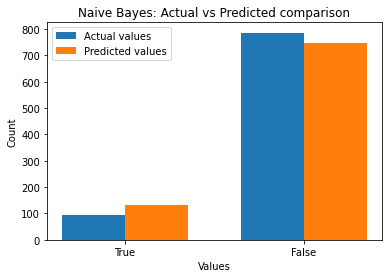

In [48]:
# Plot a Grouped Bar Chart to compare between actual and predicted values
actual_value_count = y_test.value_counts() 
y_pred_df = pd.DataFrame({'y_pred': y_pred})
pred_value_count = y_pred_df.value_counts() 

x_labels = ['True', 'False']
y_values_1 = [actual_value_count[1], actual_value_count[0]]  # Values for the first group
y_values_2 = [pred_value_count[1], pred_value_count[0]]  # Values for the second group

bar_width = 0.35

x_pos = np.arange(len(x_labels))

plt.bar(x_pos, y_values_1, width=bar_width, label='Actual values')
plt.bar(x_pos + bar_width, y_values_2, width=bar_width, label='Predicted values')

plt.xticks(x_pos + bar_width / 2, x_labels)

plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Naive Bayes: Actual vs Predicted comparison')

plt.legend()
plt.show()

## Model 2: Support Vector Machine (SVM)

In [49]:
# Use SVM classifier to predict ROSTERSTATUS

# Train test split
X = playerlist_data_final
y = playerlist_data['ROSTERSTATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Construct the NB model
svm_clf = svm.SVC(kernel='rbf', gamma='auto') 

# Train the model using the training sets
svm_clf.fit(X_train, y_train) 

# Predict y based on X test set
y_pred = svm_clf.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

# Print model results
svm_result = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'], 'Results': [svm_accuracy, svm_precision, svm_recall, svm_f1]})
svm_result.set_index('Metrics', inplace=True)

svm_result

,Results
Metrics,
Accuracy,0.923777
Precision,1.000000
Recall,0.279570
F1 Score,0.436975


### Compare actual and predicted values

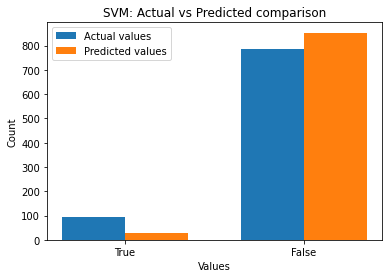

In [50]:
# Plot a Grouped Bar Chart to compare between actual and predicted values
actual_value_count = y_test.value_counts() 
y_pred_df = pd.DataFrame({'y_pred': y_pred})
pred_value_count = y_pred_df.value_counts() 

x_labels = ['True', 'False']
y_values_1 = [actual_value_count[1], actual_value_count[0]]  # Values for the first group
y_values_2 = [pred_value_count[1], pred_value_count[0]]  # Values for the second group

bar_width = 0.35

x_pos = np.arange(len(x_labels))

plt.bar(x_pos, y_values_1, width=bar_width, label='Actual values')
plt.bar(x_pos + bar_width, y_values_2, width=bar_width, label='Predicted values')

plt.xticks(x_pos + bar_width / 2, x_labels)

plt.xlabel('Values')
plt.ylabel('Count')
plt.title('SVM: Actual vs Predicted comparison')

plt.legend()
plt.show()

## Classification Problem 2:
#### Predict the possibility of EVENTMSGTYPE based on the NBA data

### Prepare dataset

In [51]:
# Use NBA Season dataset
nba_data = NBA_data

In [52]:
# Drop unnecessary columns
drop_list = ['EVENTMSGTYPE', 'EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'HOMEDESCRIPTION', 'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'SCORE', 'VISITORDESCRIPTION']
nba_data_final = nba_data.drop(nba_data[drop_list], axis=1)

nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,WCTIMESTRING,SEASON
0,21600229,0,0,12:00,1,-,-,-,0,7:41 PM,2016-2017
1,21600229,1,0,12:00,1,4,5,5,0,7:41 PM,2016-2017
2,21600229,2,57,11:39,1,5,-,-,-2,7:41 PM,2016-2017
3,21600229,3,1,11:28,1,4,5,-,0,7:42 PM,2016-2017
4,21600229,4,41,11:25,1,5,5,-,-4,7:42 PM,2016-2017


### Convert columns datatype to numerical

In [53]:
# Convert WCTIMESTRING column datatype
nba_data_final['WCTIMESTRING'] = pd.to_datetime(nba_data_final['WCTIMESTRING'])
nba_data_final['WCTIME_Hour'] = nba_data_final['WCTIMESTRING'].dt.hour
nba_data_final['WCTIME_Minute'] = nba_data_final['WCTIMESTRING'].dt.minute

# Drop original WCTIMESTRING column
nba_data_final = nba_data_final.drop('WCTIMESTRING', axis=1)
nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,SEASON,WCTIME_Hour,WCTIME_Minute
0,21600229,0,0,12:00,1,-,-,-,0,2016-2017,19,41
1,21600229,1,0,12:00,1,4,5,5,0,2016-2017,19,41
2,21600229,2,57,11:39,1,5,-,-,-2,2016-2017,19,41
3,21600229,3,1,11:28,1,4,5,-,0,2016-2017,19,42
4,21600229,4,41,11:25,1,5,5,-,-4,2016-2017,19,42


In [54]:
# Convert PCTIMESTRING column datatype
temp_df = pd.DataFrame(columns=['Minutes', 'Seconds'])
temp_df = nba_data_final['PCTIMESTRING'].str.split(':', expand=True)

# Convert minutes and seconds to numeric values
nba_data_final['PCTIME_Minute'] = temp_df[0].astype(int)
nba_data_final['PCTIME_Second'] = temp_df[1].astype(int)

# Drop original PCTIMESTRING column
nba_data_final = nba_data_final.drop('PCTIMESTRING', axis=1)
nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,SEASON,WCTIME_Hour,WCTIME_Minute,PCTIME_Minute,PCTIME_Second
0,21600229,0,0,1,-,-,-,0,2016-2017,19,41,12,0
1,21600229,1,0,1,4,5,5,0,2016-2017,19,41,12,0
2,21600229,2,57,1,5,-,-,-2,2016-2017,19,41,11,39
3,21600229,3,1,1,4,5,-,0,2016-2017,19,42,11,28
4,21600229,4,41,1,5,5,-,-4,2016-2017,19,42,11,25


In [55]:
# Replace "-" with 0
nba_data_final = nba_data_final.replace('-', 0)

# Replace "TIE" value in SCOREMARGIN column
nba_data_final['SCOREMARGIN'] = nba_data_final['SCOREMARGIN'].replace('TIE', 0)

nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,SEASON,WCTIME_Hour,WCTIME_Minute,PCTIME_Minute,PCTIME_Second
0,21600229,0,0,1,0,0,0,0,2016-2017,19,41,12,0
1,21600229,1,0,1,4,5,5,0,2016-2017,19,41,12,0
2,21600229,2,57,1,5,0,0,-2,2016-2017,19,41,11,39
3,21600229,3,1,1,4,5,0,0,2016-2017,19,42,11,28
4,21600229,4,41,1,5,5,0,-4,2016-2017,19,42,11,25


### Label Encoding

In [56]:
# Apply Label Encoding to convert to numerical data

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'SEASON' column
nba_data_final['SEASON_ENCODED'] = label_encoder.fit_transform(nba_data_final['SEASON'])

# Drop original SEASON column
nba_data_final = nba_data_final.drop('SEASON', axis=1)
nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,WCTIME_Hour,WCTIME_Minute,PCTIME_Minute,PCTIME_Second,SEASON_ENCODED
0,21600229,0,0,1,0,0,0,0,19,41,12,0,0
1,21600229,1,0,1,4,5,5,0,19,41,12,0,0
2,21600229,2,57,1,5,0,0,-2,19,41,11,39,0
3,21600229,3,1,1,4,5,0,0,19,42,11,28,0
4,21600229,4,41,1,5,5,0,-4,19,42,11,25,0


In [57]:
# Convert object datatype columns to int datatype
object_columns = nba_data_final.select_dtypes(include='object').columns
nba_data_final[object_columns] = nba_data_final[object_columns].astype(int)
nba_data_final.head()

,GAME_ID,EVENTNUM,EVENTMSGACTIONTYPE,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,SCOREMARGIN,WCTIME_Hour,WCTIME_Minute,PCTIME_Minute,PCTIME_Second,SEASON_ENCODED
0,21600229,0,0,1,0,0,0,0,19,41,12,0,0
1,21600229,1,0,1,4,5,5,0,19,41,12,0,0
2,21600229,2,57,1,5,0,0,-2,19,41,11,39,0
3,21600229,3,1,1,4,5,0,0,19,42,11,28,0
4,21600229,4,41,1,5,5,0,-4,19,42,11,25,0


### Final check all column datatypes

In [58]:
# Make sure all columns are numerical
nba_data_final.dtypes

GAME_ID               int32
EVENTNUM              int64
EVENTMSGACTIONTYPE    int64
PERIOD                int32
PERSON1TYPE           int32
PERSON2TYPE           int32
PERSON3TYPE           int32
SCOREMARGIN           int32
WCTIME_Hour           int64
WCTIME_Minute         int64
PCTIME_Minute         int32
PCTIME_Second         int32
SEASON_ENCODED        int32
dtype: object

## Model 1: Naive Bayes

In [59]:
# Use Naive Bayes classifier to predict EVENTMSGTYPE

# Train test split
X = nba_data_final
y = nba_data['EVENTMSGTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Construct the NB model
nb = GaussianNB()

# Train the model using the training sets
nb.fit(X_train, y_train) 

# Predict y based on X test set
y_pred = nb.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred, average='macro')
nb_recall = recall_score(y_test, y_pred, average='macro')
nb_f1 = f1_score(y_test, y_pred, average='macro')

# Print model results
nb_result = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'], 'Results': [nb_accuracy, nb_precision, nb_recall, nb_f1]})
nb_result.set_index('Metrics', inplace=True)

nb_result

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Results
Metrics,
Accuracy,0.663464
Precision,0.600623
Recall,0.523638
F1 Score,0.504526


### Compare actual and predicted values

In [60]:
# Compare y_test and y_pred values
compare_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Add a new column to check if the values are the same
compare_df['Match'] = compare_df['y_test'] == compare_df['y_pred']

compare_df

,y_test,y_pred,Match
254365,2,4,False
481638,1,1,True
483141,6,8,False
315783,8,8,True
35777,6,8,False
...,...,...,...
306993,3,3,True
4745,2,4,False
25044,4,4,True
570184,4,4,True


In [61]:
# Print number of Matches
compare_df['Match'].value_counts()

True     156827
False     79549
Name: Match, dtype: int64

## Model 2: Logistic Regression

In [62]:
# Use Logistic Regression classifier to predict EVENTMSGTYPE

# Split the data into training and test sets
X = nba_data_final
y = nba_data['EVENTMSGTYPE']
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=2) # 20% test set, 80% training set

# Create the linear regression model
logisticReg = LogisticRegression()

# Train the model on the training data
logisticReg.fit(X_train, y_train)

# Evaluate the model
lg_accuracy = accuracy_score(y_test, y_pred)
lg_precision = precision_score(y_test, y_pred, average='macro')
lg_recall = recall_score(y_test, y_pred, average='macro')
lg_f1 = f1_score(y_test, y_pred, average='macro')

# Print model results
lg_result = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'], 'Results': [nb_accuracy, nb_precision, nb_recall, nb_f1]})
lg_result.set_index('Metrics', inplace=True)

lg_result

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Results
Metrics,
Accuracy,0.663464
Precision,0.600623
Recall,0.523638
F1 Score,0.504526



### Compare actual and predicted values

In [63]:
# Compare y_test and y_pred values
compare_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Add a new column to check if the values are the same
compare_df['Match'] = compare_df['y_test'] == compare_df['y_pred']

compare_df

,y_test,y_pred,Match
49853,12,4,False
45156,5,1,False
411616,8,8,True
334797,3,8,False
285935,4,8,False
...,...,...,...
564675,4,3,False
410926,2,4,False
184779,4,4,True
265217,9,4,False


In [64]:
# Print number of Matches
compare_df['Match'].value_counts()

False    197528
True      38848
Name: Match, dtype: int64

## Part 3: Cluster Analysis

Group players together based on similarities in their performance.

### Read dataset

In [65]:
NBA_data = pd.read_csv('nba_cleaned.csv')
NBA_data_LE = NBA_data[['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE', 'SCOREMARGIN']]
NBA_data_LE

,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE_DESCRIPTION,SCORE,SCOREMARGIN
0,PERIOD_BEGIN,-,0 - 0,0
1,JUMP_BALL,-,0 - 0,0
2,FIELD_GOAL_MADE,-,2 - 0,-2
3,TURNOVER,3PT_JUMP_SHOT,0 - 0,0
4,FIELD_GOAL_MADE,RUNNING_LAYUP,4 - 0,-4
...,...,...,...,...
1181875,TIMEOUT,3PT_JUMP_SHOT,0 - 0,0
1181876,SUBSTITUTION,-,0 - 0,0
1181877,FIELD_GOAL_MISSED,-,0 - 0,0
1181878,REBOUND,-,0 - 0,0


In [66]:
NBA_data.columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGTYPE_DESCRIPTION',
       'EVENTMSGACTIONTYPE', 'EVENTMSGACTIONTYPE_DESCRIPTION',
       'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'PERSON1TYPE',
       'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID', 'PLAYER1_NAME',
       'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'],
      dtype='object')

In [67]:
NBA_data_LE.columns

Index(['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE',
       'SCOREMARGIN'],
      dtype='object')

### Label encoding

In [68]:
# Select relevant columns for clustering
columns_for_clustering = ['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE', 'SCOREMARGIN']

encoders = {}
for col in columns_for_clustering:
    encoders[col] = LabelEncoder()

# Encode the object columns in the DataFrame
for col in columns_for_clustering:
    NBA_data_LE[col] = encoders[col].fit_transform(NBA_data_LE[col])

NBA_data_LE

C:\Users\ARYSSA~1\AppData\Local\Temp/ipykernel_4872/3463745842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NBA_data_LE[col] = encoders[col].fit_transform(NBA_data_LE[col])


,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE_DESCRIPTION,SCORE,SCOREMARGIN
0,7,0,0,58
1,6,0,0,58
2,2,0,2917,11
3,12,1,0,58
4,2,20,4118,33
...,...,...,...,...
1181875,11,1,0,58
1181876,10,0,0,58
1181877,3,0,0,58
1181878,9,0,0,58


###  Elbow method
Find the best number of clusters we should use.

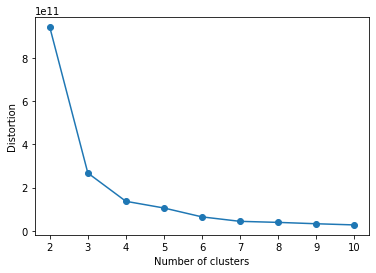

In [71]:
distortions = []
for i in range(2, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=100,
        tol=1e-04, random_state=0
    )
    km.fit(NBA_data_LE)
    distortions.append(km.inertia_)

# plot
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### K-Mean Clustering

In [72]:
# Apply k-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
NBA_data_LE['Cluster'] = kmeans.fit_predict(NBA_data_LE)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Create a DataFrame to store the cluster centers
centers_df = pd.DataFrame(centers, columns=columns_for_clustering)
centers_df.index = np.arange(1, len(centers_df) + 1)

# Display the cluster centers
display(centers_df)

,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE_DESCRIPTION,SCORE,SCOREMARGIN
1,6.871000,2.288714,34.071716,57.837651
2,3.142104,4.994741,7155.195951,58.472360
3,3.086002,5.293337,3918.663388,62.436990


### Characteristic of each clusters

In [73]:
# Iterate over each cluster
for cluster_num in range(1, len(centers_df) + 1):
    
    # Get the integer part of the first value in each column
    score_int = int(centers_df['SCORE'].iloc[cluster_num - 1])
    scoremargin_int = int(centers_df['SCOREMARGIN'].iloc[cluster_num - 1])

    # Identify the label's classes
    print("Cluster", cluster_num, "characteristic ==================================")
    print('SCORE cluster', cluster_num, ':', encoders['SCORE'].classes_[score_int])
    print('SCOREMARGIN cluster', cluster_num, ':', encoders['SCOREMARGIN'].classes_[scoremargin_int])
    print()

Cluster 1 characteristic ==================================
SCORE cluster 1 : 10 - 0
SCOREMARGIN cluster 1 : -9

Cluster 2 characteristic ==================================
SCORE cluster 2 : 79 - 124
SCOREMARGIN cluster 2 : 0

Cluster 3 characteristic ==================================
SCORE cluster 3 : 36 - 70
SCOREMARGIN cluster 3 : 12



> <b>Cluster 1:</b>
><li>The average score in this cluster is low, with score of 10 - 0.</li>
><li>The score margin is -9, implying that the team is trailing by 9 points on average.</li>
><li>The players in this cluster can be represent as the low performance player.</li>
>
><b>Cluster 2:</b>
><li>The average score in this cluster is moderate, with score of 79 - 124.</li>
><li>The score margin is 0, suggesting that there is no significant lead for either team.</li>
><li>The players in this cluster can be represent as the average performance player.</li>
>
><b>Cluster 3:</b>
><li>The average score in this cluster is high, with score of 36 - 70.</li>
><li>The score margin is 12, indicating that the team has a lead of 12 points on average</li>
><li>The players in this cluster can be represent as the high performance player.</li>

In [74]:
print('EVENTMSGTYPE_DESCRIPTION cluster', cluster_num, ':', encoders['EVENTMSGTYPE_DESCRIPTION'].classes_[3])

EVENTMSGTYPE_DESCRIPTION cluster 3 : FIELD_GOAL_MISSED


In [75]:
# Retrieve the data for each cluster
cluster_1_data = NBA_data[NBA_data_LE['Cluster'] == 0]
cluster_2_data = NBA_data[NBA_data_LE['Cluster'] == 1]
cluster_3_data = NBA_data[NBA_data_LE['Cluster'] == 2]

# Retrieve the data for each cluster
cluster_1_data = NBA_data.loc[cluster_1_data.index, ['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE', 'SCOREMARGIN']]
cluster_2_data = NBA_data.loc[cluster_2_data.index, ['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE', 'SCOREMARGIN']]
cluster_3_data = NBA_data.loc[cluster_3_data.index, ['EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION', 'SCORE', 'SCOREMARGIN']]

cluster_1_data

,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE_DESCRIPTION,SCORE,SCOREMARGIN
0,PERIOD_BEGIN,-,0 - 0,0
1,JUMP_BALL,-,0 - 0,0
3,TURNOVER,3PT_JUMP_SHOT,0 - 0,0
5,FIELD_GOAL_MISSED,3PT_JUMP_SHOT,0 - 0,0
6,REBOUND,-,0 - 0,0
...,...,...,...,...
1181875,TIMEOUT,3PT_JUMP_SHOT,0 - 0,0
1181876,SUBSTITUTION,-,0 - 0,0
1181877,FIELD_GOAL_MISSED,-,0 - 0,0
1181878,REBOUND,-,0 - 0,0


### Comparison of each cluster for EVENTMSGTYPE and EVENTMSGACTIONTYPE

In [76]:
# Retrieve the data for each cluster
cluster_1_data = NBA_data[NBA_data_LE['Cluster'] == 0]
cluster_2_data = NBA_data[NBA_data_LE['Cluster'] == 1]
cluster_3_data = NBA_data[NBA_data_LE['Cluster'] == 2]

# Retrieve the eventmsg for each cluster
cluster_1_eventmsg = NBA_data.loc[cluster_1_data.index, 'EVENTMSGTYPE_DESCRIPTION']
cluster_2_eventmsg = NBA_data.loc[cluster_2_data.index, 'EVENTMSGTYPE_DESCRIPTION']
cluster_3_eventmsg = NBA_data.loc[cluster_3_data.index, 'EVENTMSGTYPE_DESCRIPTION']

# Retrieve the eventactionmsg for each cluster
cluster_1_eventactionmsg = NBA_data.loc[cluster_1_data.index, 'EVENTMSGACTIONTYPE_DESCRIPTION']
cluster_2_eventactionmsg = NBA_data.loc[cluster_2_data.index, 'EVENTMSGACTIONTYPE_DESCRIPTION']
cluster_3_eventactionmsg = NBA_data.loc[cluster_3_data.index, 'EVENTMSGACTIONTYPE_DESCRIPTION']

# Create DataFrames for each cluster
cluster_1_df = pd.DataFrame({
    'Eventmsg': cluster_1_eventmsg.values,
    'Eventactionmsg': cluster_1_eventactionmsg.values
})

cluster_2_df = pd.DataFrame({
    'Eventmsg': cluster_2_eventmsg.values,
    'Eventactionmsg': cluster_2_eventactionmsg.values
})

cluster_3_df = pd.DataFrame({
    'Eventmsg': cluster_3_eventmsg.values,
    'Eventactionmsg': cluster_3_eventactionmsg.values
})

<b> Cluster 1

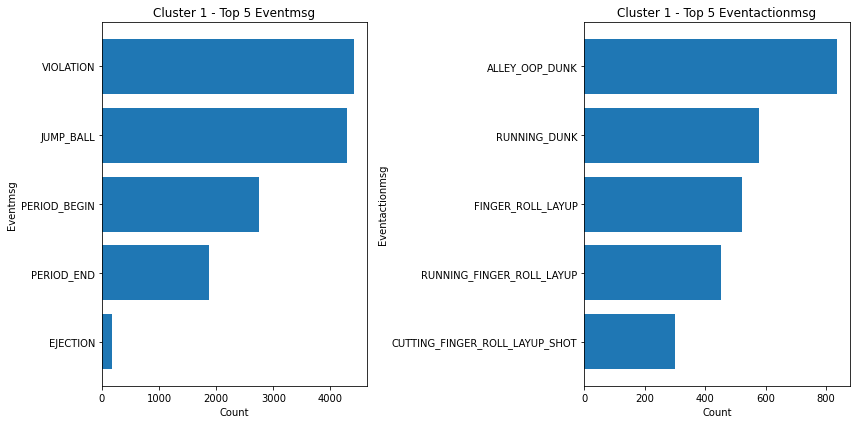

In [77]:
# Value counts for Eventmsg
eventmsg_counts = cluster_1_df['Eventmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventmsg_counts.index:
    eventmsg_counts = eventmsg_counts.drop('-')

# Sort values in descending order
eventmsg_counts = eventmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventmsg_counts = eventmsg_counts.head(5)

# Value counts for Eventactionmsg
eventactionmsg_counts = cluster_1_df['Eventactionmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventactionmsg_counts.index:
    eventactionmsg_counts = eventactionmsg_counts.drop('-')

# Sort values in descending order
eventactionmsg_counts = eventactionmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventactionmsg_counts = eventactionmsg_counts.head(5)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Eventmsg horizontal bar chart
ax1.barh(top_eventmsg_counts.index, top_eventmsg_counts.values)
ax1.set_xlabel('Count')
ax1.set_ylabel('Eventmsg')
ax1.set_title('Cluster 1 - Top 5 Eventmsg')

# Plot Eventactionmsg horizontal bar chart
ax2.barh(top_eventactionmsg_counts.index, top_eventactionmsg_counts.values)
ax2.set_xlabel('Count')
ax2.set_ylabel('Eventactionmsg')
ax2.set_title('Cluster 1 - Top 5 Eventactionmsg')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

> Cluster 1 is characterized by players with low performance. Within this cluster, players frequently face violations, which refer to rule infractions during gameplay, and jump ball situations, which occur when two opposing players simultaneously gain possession of the ball. These events indicate challenges and struggles faced by the players in this cluster. Also, players in Cluster 1 demonstrate strong offensive skills, as evidenced by the frequent occurrence of the alley-oop dunk.

<b> Cluster 2

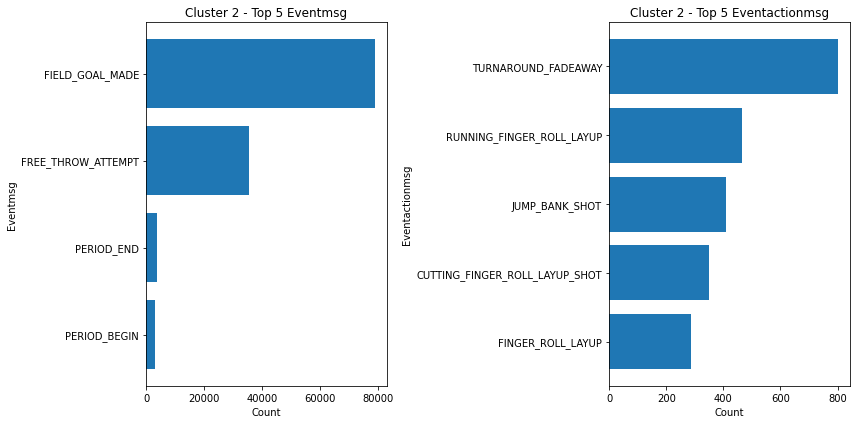

In [78]:
# Value counts for Eventmsg
eventmsg_counts = cluster_2_df['Eventmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventmsg_counts.index:
    eventmsg_counts = eventmsg_counts.drop('-')

# Sort values in descending order
eventmsg_counts = eventmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventmsg_counts = eventmsg_counts.head(5)

# Value counts for Eventactionmsg
eventactionmsg_counts = cluster_2_df['Eventactionmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventactionmsg_counts.index:
    eventactionmsg_counts = eventactionmsg_counts.drop('-')

# Sort values in descending order
eventactionmsg_counts = eventactionmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventactionmsg_counts = eventactionmsg_counts.head(5)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Eventmsg horizontal bar chart
ax1.barh(top_eventmsg_counts.index, top_eventmsg_counts.values)
ax1.set_xlabel('Count')
ax1.set_ylabel('Eventmsg')
ax1.set_title('Cluster 2 - Top 5 Eventmsg')

# Plot Eventactionmsg horizontal bar chart
ax2.barh(top_eventactionmsg_counts.index, top_eventactionmsg_counts.values)
ax2.set_xlabel('Count')
ax2.set_ylabel('Eventactionmsg')
ax2.set_title('Cluster 2 - Top 5 Eventactionmsg')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

>Cluster 2 consists of players with average performance. Within this cluster, players display consistent shooting ability and earn free throw opportunities when fouled by opponents. The most frequently used actions by players in this cluster are the turnaround fadeaway, running finger roll layup, and jump bank shot. These actions reflect their skill in executing challenging and effective moves, contributing to their performance level within Cluster 2.

<b> Cluster 3

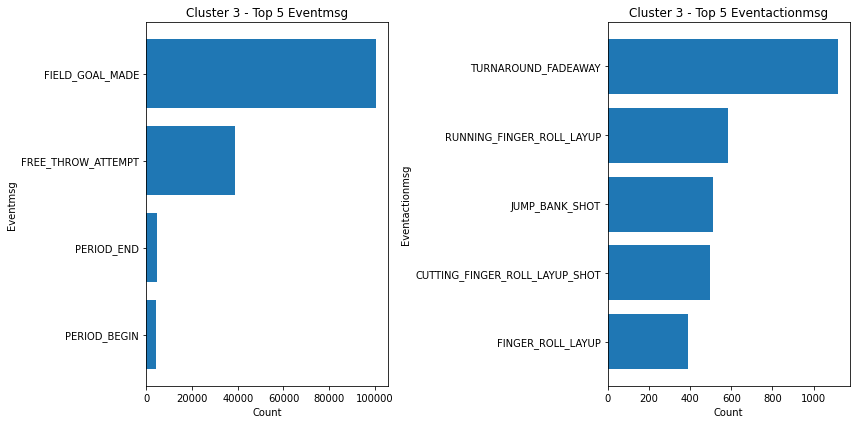

In [79]:
# Value counts for Eventmsg
eventmsg_counts = cluster_3_df['Eventmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventmsg_counts.index:
    eventmsg_counts = eventmsg_counts.drop('-')

# Sort values in descending order
eventmsg_counts = eventmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventmsg_counts = eventmsg_counts.head(5)

# Value counts for Eventactionmsg
eventactionmsg_counts = cluster_3_df['Eventactionmsg'].value_counts()

# Remove the "-" value if it exists
if '-' in eventactionmsg_counts.index:
    eventactionmsg_counts = eventactionmsg_counts.drop('-')

# Sort values in descending order
eventactionmsg_counts = eventactionmsg_counts.sort_values(ascending=True)

# Select the top 5 values
top_eventactionmsg_counts = eventactionmsg_counts.head(5)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Eventmsg horizontal bar chart
ax1.barh(top_eventmsg_counts.index, top_eventmsg_counts.values)
ax1.set_xlabel('Count')
ax1.set_ylabel('Eventmsg')
ax1.set_title('Cluster 3 - Top 5 Eventmsg')

# Plot Eventactionmsg horizontal bar chart
ax2.barh(top_eventactionmsg_counts.index, top_eventactionmsg_counts.values)
ax2.set_xlabel('Count')
ax2.set_ylabel('Eventactionmsg')
ax2.set_title('Cluster 3 - Top 5 Eventactionmsg')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

>Cluster 3 represents players with high performance. In this cluster, players demonstrate exceptional skills by consistently making successful shots and earning opportunities to attempt free throws, which are awarded when fouled by an opposing player. The most common action used by players in this cluster is the turnaround fadeaway, running finger rol layup and jump bank shot. These actions highlight the players' ability to execute challenging and effective moves, contributing to their high-performance status within Cluster 3.

## Summary